In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
/device:GPU:0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import seaborn as sns
import numpy as np
import IPython
import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import Model,layers

In [4]:
local_zip = '/content/drive/My Drive/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
base_dir = '/tmp/chest_xray'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
val_dir = os.path.join(base_dir,'val')
train_normal_dir = os.path.join(train_dir,'NORMAL')
train_affected_dir = os.path.join(train_dir,'PNEUMONIA')

In [6]:
IMG_SIZE  = 200
# Data augmentation using 'ImageDataGenerator'
train_data_gen = ImageDataGenerator(rescale = 1/255, rotation_range = 30, 
                               zoom_range = 0.2, width_shift_range = 0.2, 
                               height_shift_range = 0.2, horizontal_flip = True)
train_data = train_data_gen.flow_from_directory(train_dir,target_size = (IMG_SIZE,IMG_SIZE), class_mode = 'binary')

data_gen = ImageDataGenerator(rescale = 1/255)
val_data = data_gen.flow_from_directory(val_dir,target_size = (IMG_SIZE,IMG_SIZE), class_mode = 'binary')

test_data = data_gen.flow_from_directory(test_dir,target_size = (IMG_SIZE,IMG_SIZE), class_mode = 'binary')

Found 5208 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [48]:
saved_model_path= '/content/drive/My Drive/downloaded files/BINARY.h5'
model= tf.keras.models.load_model(saved_model_path)

In [49]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_data)
print("test loss, test acc:", results)


Evaluate on test data
20/20 [==============================] - 6s 286ms/step - loss: 0.3872 - precision: 0.9302 - recall: 0.9231 - accuracy: 0.9087
test loss, test acc: [0.38724660873413086, 0.930232584476471, 0.9230769276618958, 0.9086538553237915]


In [52]:
train_normal_dir = os.path.join(train_dir,'NORMAL')
train_affected_dir = os.path.join(train_dir,'PNEUMONIA')

train_normal_fnames = os.listdir(train_normal_dir)
train_affected_fnames = os.listdir(train_affected_dir)

COUNT_NORMAL = len(train_normal_fnames)
COUNT_AFFECTED = len(train_affected_fnames)
TRAIN_IMG_COUNT = COUNT_AFFECTED + COUNT_NORMAL
initial_bias = np.log([COUNT_AFFECTED/COUNT_NORMAL])

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_AFFECTED)*(TRAIN_IMG_COUNT)/2.0

# Initializing class-weights to correct the data imbalance 
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [53]:
# Fine training the model with a lower learning rate 
model.compile(optimizer = RMSprop(lr = 0.0001), loss = 'binary_crossentropy',metrics= [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
epochs_to_wait_for_improve = 10
n_epochs = 25
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint('BINARY'+'.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_data,validation_data=val_data,class_weight= class_weight,
            epochs=n_epochs, callbacks=[early_stopping_callback, checkpoint_callback])


Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 0.1842 - precision_1: 0.9912 - recall_1: 0.9279 - accuracy: 0.9403
Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to BINARY.h5
163/163 [==============================] - 97s 595ms/step - loss: 0.1842 - precision_1: 0.9912 - recall_1: 0.9279 - accuracy: 0.9403 - val_loss: 0.1400 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - val_accuracy: 1.0000
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 0.1678 - precision_1: 0.9917 - recall_1: 0.9284 - accuracy: 0.9411
Epoch 00002: val_accuracy did not improve from 1.00000
163/163 [==============================] - 94s 578ms/step - loss: 0.1678 - precision_1: 0.9917 - recall_1: 0.9284 - accuracy: 0.9411 - val_loss: 0.1414 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - val_accuracy: 1.0000
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.1681 - precision_1: 0.9931 - recall_1: 0.9299 - accuracy: 0.9432
Epo

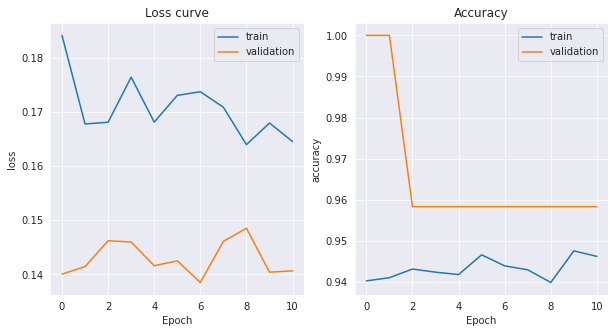

In [55]:
sns.set_style("darkgrid")
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

#get the entries
xvalues = np.arange(len(train_acc))

#visualise
f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues,  train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

In [59]:
print("Evaluate on test data")
results = model.evaluate(test_data)
print("test loss, test acc:", results)

Evaluate on test data
20/20 [==============================] - 6s 277ms/step - loss: 0.2983 - precision_1: 0.9160 - recall_1: 0.9513 - accuracy: 0.9151
test loss, test acc: [0.29831308126449585, 0.9160493612289429, 0.9512820243835449, 0.9150640964508057]
